In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde

In [2]:
def load_data():
    raw_data=pd.read_csv("Weather Data.csv")
    weather_data = raw_data.copy()

    #typo
    weather_data.rename(columns={'Longitute':"Longitude"},inplace=True)

    #to make sure all states/provinces has space at the beginning
    for index, state in enumerate(weather_data['State/Province']):
        if state == 'Australian Capital Territory':
            weather_data.loc[index, 'State/Province'] = ' Australian Capital Territory'

    #remove ID column
    weather_data = weather_data.drop(['row ID'],axis=1)

    #remove rows with null values from WindGustDir
    weather_data = weather_data.dropna(subset=['WindGustDir'])

    #fill rows with null values with the mode for WindDir9am and WindDir3pm
    mode_winddir9am = weather_data['WindDir9am'].mode().iloc[0]
    mode_winddir3pm = weather_data['WindDir3pm'].mode().iloc[0]
    weather_data['WindDir9am'] = weather_data['WindDir9am'].fillna(mode_winddir9am)
    weather_data['WindDir3pm'] = weather_data['WindDir3pm'].fillna(mode_winddir3pm)

    #Cloud9am
    missing_indices = weather_data['Cloud9am'].isnull()
    num_missing = missing_indices.sum()
    non_missing_data = weather_data.loc[~missing_indices,'Cloud9am']
    probabilities = non_missing_data.value_counts(normalize=True) # the relative frequencies (probabilities) instead of the actual counts.
    random_values = np.random.choice(probabilities.index, size=num_missing, p=probabilities.values)
    weather_data.loc[missing_indices,'Cloud9am'] = random_values

    #Cloud3pm
    missing_indices = weather_data['Cloud3pm'].isnull()
    num_missing = missing_indices.sum()
    non_missing_data = weather_data.loc[~missing_indices,'Cloud3pm']
    probabilities = non_missing_data.value_counts(normalize=True) # the relative frequencies (probabilities) instead of the actual counts.
    random_values = np.random.choice(probabilities.index, size=num_missing, p=probabilities.values)
    weather_data.loc[missing_indices,'Cloud3pm'] = random_values

    #RainToday
    raw_data = weather_data[weather_data['RainToday'].notnull()]

    #RainTomorrow - completed
    
    return raw_data


In [3]:
weather_data = load_data()

In [4]:
weather_data.head()

,Location,State/Province,Latitude,Longitude,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,New South Wales,-36.0737,146.9135,13.4,22.9,0.6,NaN,NaN,W,...,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,No,0
1,Albury,New South Wales,-36.0737,146.9135,7.4,25.1,0.0,NaN,NaN,WNW,...,44.0,25.0,1010.6,1007.8,5.0,2.0,17.2,24.3,No,0
2,Albury,New South Wales,-36.0737,146.9135,17.5,32.3,1.0,NaN,NaN,W,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Albury,New South Wales,-36.0737,146.9135,14.6,29.7,0.2,NaN,NaN,WNW,...,55.0,23.0,1009.2,1005.4,7.0,2.0,20.6,28.9,No,0
4,Albury,New South Wales,-36.0737,146.9135,7.7,26.7,0.0,NaN,NaN,W,...,48.0,19.0,1013.4,1010.1,7.0,0.0,16.3,25.5,No,0


In [5]:
weather_data.shape

(92137, 25)

In [6]:
round( weather_data.isnull().sum()/ weather_data.shape[0] *100,1)

Location           0.0
State/Province     0.0
Latitude           0.0
Longitude          0.0
MinTemp            0.1
MaxTemp            0.0
Rainfall           0.0
Evaporation       42.0
Sunshine          46.9
WindGustDir        0.0
WindGustSpeed      0.0
WindDir9am         0.0
WindDir3pm         0.0
WindSpeed9am       0.1
WindSpeed3pm       0.2
Humidity9am        0.9
Humidity3pm        1.4
Pressure9am        7.5
Pressure3pm        7.6
Cloud9am           0.0
Cloud3pm           0.0
Temp9am            0.3
Temp3pm            0.8
RainToday          0.0
RainTomorrow       0.0
dtype: float64

In [7]:
#weather_data = weather_data.dropna(subset=['MinTemp','Rainfall','WindSpeed9am','WindSpeed3pm','Humidity9am'])
# Often happens that missing observations occur in the same row in few variables, so that sometimes it is sufficient to 
# remove nulls just from few variables to have completed data
weather_data = weather_data.dropna(subset=['Pressure9am','Humidity3pm','Humidity9am','WindSpeed9am','MinTemp','MaxTemp','WindSpeed3pm','Pressure3pm'])

# weather_data.isnull().sum()/ weather_data.shape[0] *100
weather_data.isnull().sum()
#Attention -> function may show 0% of nulls in the row but in realty there will be some null values, however
#they occupy less than 0.1%  -> so do not use % here or do not round numbers !!! 

Location              0
State/Province        0
Latitude              0
Longitude             0
MinTemp               0
MaxTemp               0
Rainfall              0
Evaporation       31361
Sunshine          35318
WindGustDir           0
WindGustSpeed         0
WindDir9am            0
WindDir3pm            0
WindSpeed9am          0
WindSpeed3pm          0
Humidity9am           0
Humidity3pm           0
Pressure9am           0
Pressure3pm           0
Cloud9am              0
Cloud3pm              0
Temp9am               0
Temp3pm               0
RainToday             0
RainTomorrow          0
dtype: int64

In [8]:
weather_data.shape
# 83899 records still good

(83801, 25)

In [9]:
weather_data_partly_preprocessed = weather_data.copy()

In [10]:
weather_data_partly_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83801 entries, 0 to 99515
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        83801 non-null  object 
 1   State/Province  83801 non-null  object 
 2   Latitude        83801 non-null  float64
 3   Longitude       83801 non-null  float64
 4   MinTemp         83801 non-null  float64
 5   MaxTemp         83801 non-null  float64
 6   Rainfall        83801 non-null  float64
 7   Evaporation     52440 non-null  float64
 8   Sunshine        48483 non-null  float64
 9   WindGustDir     83801 non-null  object 
 10  WindGustSpeed   83801 non-null  float64
 11  WindDir9am      83801 non-null  object 
 12  WindDir3pm      83801 non-null  object 
 13  WindSpeed9am    83801 non-null  float64
 14  WindSpeed3pm    83801 non-null  float64
 15  Humidity9am     83801 non-null  float64
 16  Humidity3pm     83801 non-null  float64
 17  Pressure9am     83801 non-null 

In [11]:
columns_to_exclude = ['Latitude','Longitute','Cloud9am','Cloud3pm','RainTomorrow']
selected_columns = [col for col in weather_data_partly_preprocessed.columns if col not in columns_to_exclude]
weather_data_partly_preprocessed[selected_columns].describe()

,Longitude,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,83801.000000,83801.000000,83801.000000,83801.000000,52440.000000,48483.000000,83801.000000,83801.000000,83801.000000,83801.000000,83801.000000,83801.000000,83801.000000,83801.000000,83801.000000
mean,142.479737,12.370121,23.467071,2.322194,5.500011,7.673108,40.106347,14.366523,19.097433,68.316679,50.834871,1017.683612,1015.278637,17.161094,21.960749
std,11.611397,6.352580,6.985617,8.421803,4.201704,3.784054,13.483398,8.800974,8.670581,19.155411,20.666031,7.104837,7.030337,6.443629,6.828077
min,115.100700,-7.000000,2.600000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.200000,-3.100000,1.700000
25%,138.993900,7.800000,18.000000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,56.000000,36.000000,1013.000000,1010.500000,12.400000,16.700000
50%,145.778100,12.100000,22.900000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,69.000000,51.000000,1017.700000,1015.300000,16.800000,21.400000
75%,150.737800,17.000000,28.500000,0.600000,7.400000,10.700000,48.000000,20.000000,24.000000,83.000000,65.000000,1022.400000,1020.000000,21.800000,26.700000
max,167.954700,33.900000,48.100000,367.600000,82.400000,14.500000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000


# Numerical variables

Type numerical: **discrete/continuous** 

Discrete: can be counted in a finite matter 

Continuous: impossible to count,infinite (digits after dot)

Level of measurement: Quantitative: **interval/ratio** 

Interval: do not have true zero, we may have negative number like degress Celsisu, year (p.n.e) etc.

Ratio: have true zero, we cannot have negative number like degrees Kelvin,length,distance etc.

## Normal distribution? 
Normality is often an assumption for many statistical tests and models, so that I found it usefull to check whether the data follows normal distribution. 

How to do it?  vizualization + statistical test

Vizualization: histogram,Q-Q plots, P-P plots

Tests:

    1. for small/medium samples: Shapiro-Wilk Test, D'Agostino-Pearson Test, The Lilliefors test(modification of the Kolmogrov-Smirnow test)
    2. for larger samples: Kolmogorov-Smirnov Test,Jarque-Bera Test,Anderson-Darling Test

Additionally, for large samples, even slight deviations from a normal distribution can be detected as statistically significant.   
Methods that I will be using: 
1. histogram (with density curve), boxplot, CDF
2. Q-Q plot, P-P plot
3. Kolmogorow-Smirnov Test

In [12]:
def plot_analysis_numerical_variable(dataframe, variable, label_x, title):
    # Set up the figure and subplots with centered alignment
    fig, axes = plt.subplots(nrows=3, figsize=(6, 10), sharex=True, gridspec_kw={'width_ratios': [1], 'hspace': 0.5})

    # Plot the histogram with density curve
    sns.histplot(data=dataframe, x=variable, kde=True, ax=axes[0], color='#4F709C', bins=20)
    axes[0].set(title='Histogram with Density Curve', ylabel='Density')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot the boxplot
    sns.boxplot(data=dataframe, x=variable, ax=axes[1], color='#D8C4B6')
    axes[1].set(title='Boxplot')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot the cumulative distribution
    sorted_data = dataframe[variable].sort_values()  # in ascending order

    # Calculate the cumulative distribution
    cumulative_distribution = (np.arange(len(sorted_data)) + 1) / len(sorted_data)
    axes[2].plot(sorted_data, cumulative_distribution, marker='.', linestyle='none', color='#4F709C', markersize=2)
    # without marker I could write linewidth, because of it I have to specify the width of the curve with markersize

    axes[2].set(title='Cumulative Distribution', xlabel=label_x, ylabel='Cumulative Probability')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[2].grid(axis='x', linestyle='-', alpha=0.1)

    # Calculate mean and standard deviation
    mean = dataframe[variable].mean()
    std = dataframe[variable].std()

    # Add vertical lines for mean, mean + std, and mean - std
    def std_lines(mean,std,num,color):
        axes[0].axvline(mean + num*std, color= color, linestyle='--', label=f'±{num}σ')
        axes[0].axvline(mean - num*std, color=color, linestyle='--')
    
    axes[0].axvline(mean, color='#BA704F', linestyle='--', label='μ')
    std_lines(mean,std,1,'#5C8984')
    std_lines(mean,std,2,'#CBB279')
    std_lines(mean,std,3,'#2E4F4F')
    std_lines(mean,std,4,'grey')
    axes[0].legend()

    # Manually adjust the subplot parameters for proper alignment
    plt.subplots_adjust(hspace=0.5, top=0.9)  # top parameter adjusts the space for the title

    # Add a common title for all rows (subplots) and align it to the center
    fig.text(0.5, 0.95, title, fontsize=16, ha='center')

    # Show the plot
    plt.show()

In [13]:
#The KS statistic provides a measure of how well the data fits the theoretical distribution. A smaller KS statistic indicates a better fit between the empirical data and the theoretical distribution. Conversely, a larger KS statistic suggests a poorer fit.
def Kolmogorow_Smirnov_Test(dataframe,variable):
    test_statistic, p_value = stats.kstest(dataframe[variable], 'norm')

    if p_value < 0.05:
        print(f"Test statistic = {test_statistic}, p-value = {p_value} < 0.05: The data is not normally distributed")
    else:
        print(f"Test statistic = {test_statistic}, p-value = {p_value} >= 0.05: The data is normally distributed")

In [14]:
# probability-probability plot is used to compare CDFs (cumulative distribution functions) of two distributions(empirical and theoretical)
#When you call norm.cdf(sorted_data, loc=mean_empirical, scale=std_dev_empirical), the function will calculate the 
#cumulative distribution function (CDF) for each value in sorted_data based on the normal distribution with the given 
#parameters (mean_empirical and std_dev_empirical).
def P_P_plot(dataframe,variable):
    # Calculate empirical cumulative probability
    sorted_data = dataframe[variable].sort_values()  # in ascending order
    empirical_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Calculate theoretical cumulative probability (for normal distribution)
    mean = np.mean(sorted_data)
    std_dev = np.std(sorted_data)
    theoretical_prob = stats.norm.cdf(sorted_data, loc=mean, scale=std_dev) # both cdfs (theoretical and empirical) have the same mean and std dev

#     to see how theoretical and empirical CDF look  
#     plt.plot(sorted_data, empirical_prob, label='Empirical CDF', linestyle='-', color='blue')
#     plt.plot(sorted_data, theoretical_prob, label='Theoretical CDF', linestyle='-', color='red')

    # Create the plot
    plt.plot(empirical_prob,theoretical_prob,marker='o', linestyle=' ', color='#374259',markersize=1.5)

#     Add a 45-degree reference line
    plt.plot([0, 1], [0, 1], color='#CD1818', linestyle='--', label='45-degree Line')

    # Set plot labels and title
    plt.ylabel('Theoretical Cumulative Probability')
    plt.xlabel('Empirical Cumulative Probability')
    plt.title('P-P plot')
    #plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [15]:
# quantile-quantile (Q-Q) plot to visually compare the data to a theoretical normal distribution.
# we're comparing the quantiles of two distributions
# The x-axis represents the quantiles of the theoretical distribution, the y-axis the quantiles of the observed data.
# If the data follows the theoretical distribution closely, the points on the Q-Q plot will roughly form a straight line.
# Any deviations from the straight line indicate departures from the theoretical distribution.
# Points above the line suggest that the data's tails are heavier (larger values) than the theoretical distribution.
# Points below the line suggest that the data's tails are lighter (smaller values) than the theoretical distribution.
#In a normal distribution, the theoretical quantiles are often denoted as z-scores and represent the number of standard deviations a particular value is from the mean.
def Q_Q_plot(dataframe, variable):
    
    plt.figure(figsize=(8, 6))
    _, axes = plt.subplots()
    _, (__, ___, r) = stats.probplot(dataframe[variable], dist='norm', plot=axes)

    # Customize the marker style and color
    point_color = '#374259'
    line_color ='#CD1818'
    axes.get_lines()[0].set_marker('.')  # Marker for data points
    axes.get_lines()[0].set_color(point_color)  # Color of the data points
    axes.get_lines()[0].set_markerfacecolor(point_color)  # Color of the data point faces
    axes.get_lines()[0].set_markeredgecolor(point_color)  # Color of the data point edges
    axes.get_lines()[1].set_color(line_color)  # Color of the line connecting the points
    axes.get_lines()[1].set_linewidth(2)  # Width of the line connecting the points

    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.show()

## <span style='color: #3F2E3E;'>Temp9am/3pm - continuous - interval</span>
#### <span style='color: #A78295;'>The temperature at 9 am. / 3pm.(degree Celsius)</span>

#### Temp9am

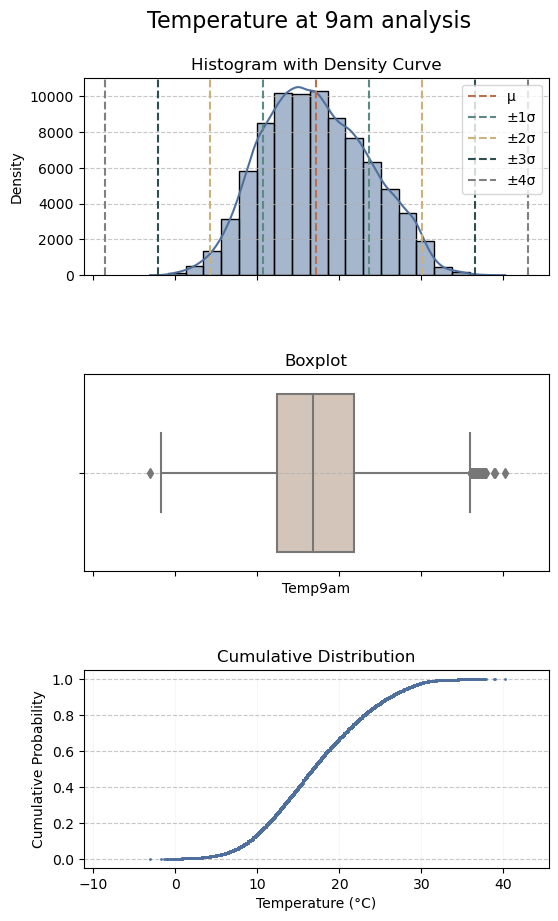

In [16]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Temp9am','Temperature (°C)','Temperature at 9am analysis')

In [17]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'Temp9am')

Test statistic = 0.9925169614101156, p-value = 0.0 < 0.05: The data is not normally distributed


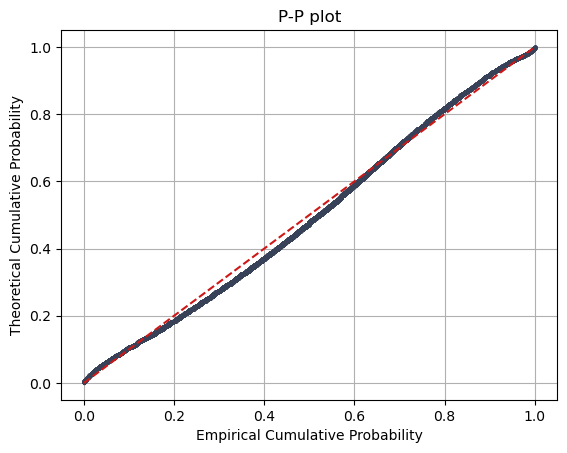

In [19]:
P_P_plot(weather_data_partly_preprocessed, 'Temp9am')

<Figure size 800x600 with 0 Axes>

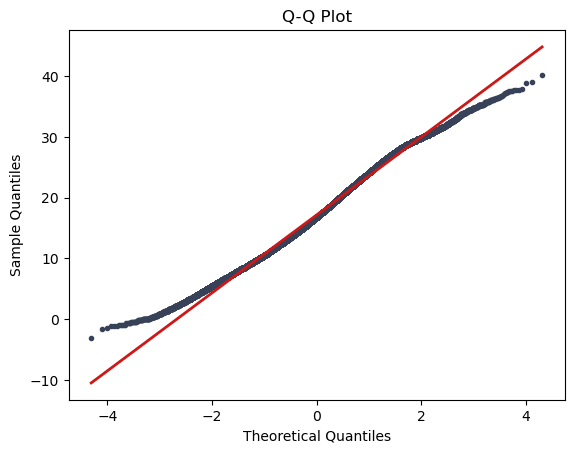

In [20]:
Q_Q_plot(weather_data_partly_preprocessed, 'Temp9am')

#### Temp3pm


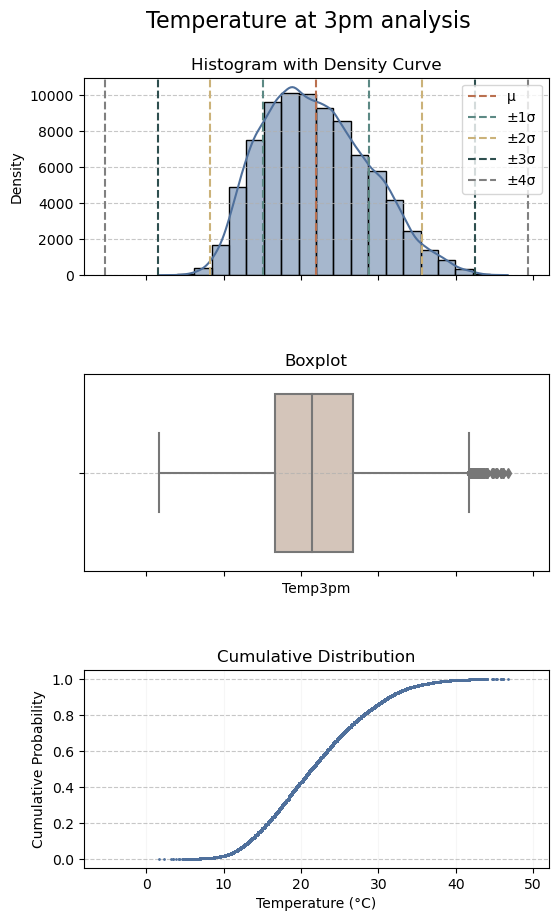

In [21]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Temp3pm','Temperature (°C)','Temperature at 3pm analysis')

In [ ]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'Temp3pm')

In [ ]:
P_P_plot(weather_data_partly_preprocessed, 'Temp3pm')

In [ ]:
Q_Q_plot(weather_data_partly_preprocessed, 'Temp3pm')

## <span style='color: #3F2E3E;'>Min/MaxTemp - continuous - interval</span>
#### <span style='color: #A78295;'>The minimum/maximum temperature during a particular day. (degree Celsius) </span>

#### MinTemp

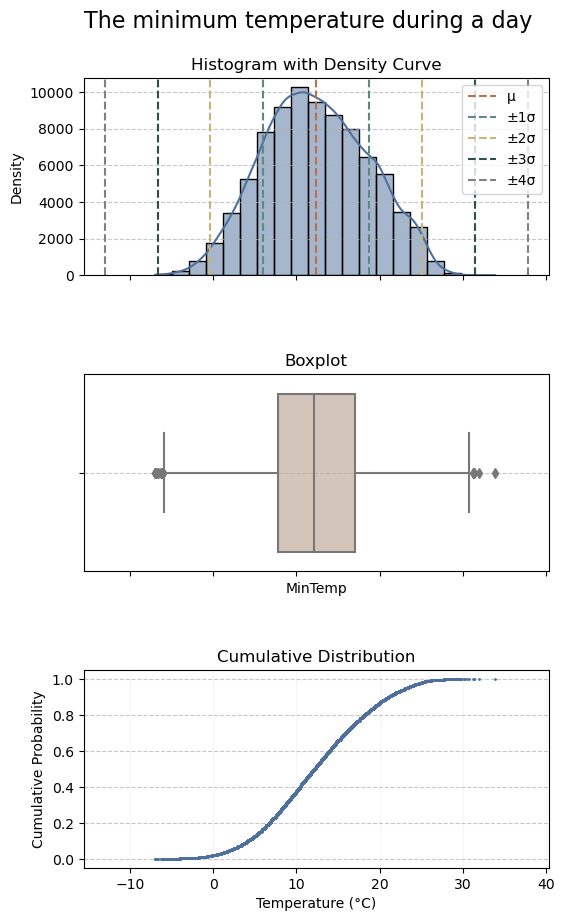

In [22]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'MinTemp','Temperature (°C)','The minimum temperature during a day')

In [ ]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'MinTemp')

In [ ]:
P_P_plot(weather_data_partly_preprocessed, 'MinTemp')

In [ ]:
Q_Q_plot(weather_data_partly_preprocessed, 'MinTemp')

#### MaxTemp

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'MaxTemp','Temperature (°C)','The maximum temperature during a day')

In [ ]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'MaxTemp')

In [ ]:
P_P_plot(weather_data_partly_preprocessed, 'MaxTemp')

In [ ]:
Q_Q_plot(weather_data_partly_preprocessed, 'MaxTemp')

## <span style='color: #3F2E3E;'>Rainfall - continuous - ratio </span>
#### <span style='color: #A78295;'>Rainfall during a particular day. (millimeters)</span>

In [ ]:
weather_data_partly_preprocessed.describe()

In [ ]:
weather_data_partly_preprocessed[weather_data_partly_preprocessed['Rainfall'] > 50 ].shape

In [ ]:
# pd.set_option('display.max_rows', None)
outliers = weather_data_partly_preprocessed[weather_data_partly_preprocessed['Rainfall'] > 50 ]
outliers['State/Province'].value_counts()
# outliers['State/Province'].nunique()

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Rainfall','Milimeters (mm)','Rainfall during a day')

In [ ]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'Rainfall')

In [ ]:
P_P_plot(weather_data_partly_preprocessed, 'Rainfall')

In [ ]:
Q_Q_plot(weather_data_partly_preprocessed, 'Rainfall')

## <span style='color: #3F2E3E;'>WindGustSpeed - continuous - ratio</span>
#### <span style='color: #A78295;'>Speed of strongest gust during a particular day. (kilometers per hour)</span>

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'WindGustSpeed','Gust speed (km/h)','Speed of strongest gust during a day')


In [ ]:
# pd.set_option('display.max_rows', None)
# sorted(weather_data_partly_preprocessed['WindGustSpeed'].unique())

## <span style='color: #3F2E3E;'>WindSpeed9am/3pm - continuous - ratio</span>
#### <span style='color: #A78295;'>Speed of the wind for 10 min prior to 9 am. / 3pm. (kilometers per hour)</span>

#### WindSpeed9am

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'WindSpeed9am','Wind speed (km/h)','Speed of the wind for 10 min prior to 9 am')

#### WindSpeed3pm

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'WindSpeed3pm','Wind speed (km/h)','Speed of the wind for 10 min prior to 3 pm')

## <span style='color: #3F2E3E;'>Humidity9am/3pm - continuous - ratio</span>
#### <span style='color: #A78295;'>The humidity of the wind at 9 am. / 3pm. (percent)</span>

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Humidity9am','Humidity (%)','The humidity of the wind at 9 am')

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Humidity3pm','Humidity (%)','The humidity of the wind at 3 pm')

## <span style='color: #3F2E3E;'>Pressure9am/3pm - continuous - ratio</span>
#### <span style='color: #A78295;'> Atmospheric pressure at 9 am. / 3pm. (hectopascals)</span>

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Pressure9am','Pressure (hPa)','Atmospheric pressure at 9 am')

In [ ]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Pressure3pm','Pressure (hPa)','Atmospheric pressure at 3 pm')

In [ ]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'Pressure9am')

In [ ]:
Kolmogorow_Smirnov_Test(weather_data_partly_preprocessed,'Pressure3pm')

In [ ]:
Q_Q_plot(weather_data_partly_preprocessed, 'Pressure9am')

In [ ]:
Q_Q_plot(weather_data_partly_preprocessed, 'Pressure3pm')

## <span style='color: #3F2E3E;'>Sunshine - continuous - ratio</span>
#### <span style='color: #A78295;'>Bright sunshine during a particular day. (hours) </span>

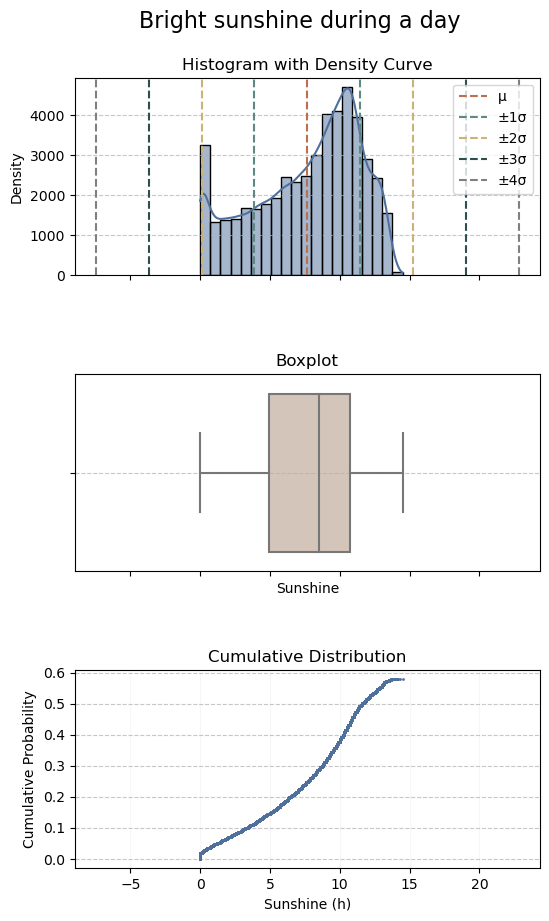

In [23]:
plot_analysis_numerical_variable(weather_data_partly_preprocessed,'Sunshine','Sunshine (h)','Bright sunshine during a day')

In [24]:
weather_data_sunshine = weather_data_partly_preprocessed.copy()
# weather_data_sunshine = weather_data_sunshine.dropna(subset='Sunshine')

In [ ]:
#weather_data_partly_preprocessed[weather_data_partly_preprocessed['Sunshine'].isnull()]['State/Province'].value_counts()

In [ ]:
# Fill the gaps -> KDE kernel density estimation for non-normally distributed data
# I also notice that in windgustspeed we have only integers, the CDE is not a continuous line, what may indicate that 
# the data distribution is higly irregular or discrete and the KDE approach may not be the most appropriate there. 
# This is because the KDE might not accurately capture the distribution, and sampling from it might lead to unrealistic imputed values.
# Fortunately, in our both examples we have continuous CDE

In [25]:
def random_imputation(df,variable):
    
    observed_data = df[variable].dropna()
    missing_indices = df[variable].isnull()

    # Fit a kernel density estimate to the observed data
    kde = gaussian_kde(observed_data)

    # Get the number of missing values
    num_missing = missing_indices.sum()

    # Generate random values from the KDE
    random_values = np.round(np.abs(kde.resample(num_missing)[0]),1) # at the beginning I did not ensure that my outputs remain positive, np.abs was important step! (now the distributions are similar, before not really)

    # Fill missing values with random values
    df.loc[missing_indices, variable] = random_values
    
    return df

In [26]:
weather_data_sunshine = random_imputation(weather_data_sunshine, 'Sunshine')

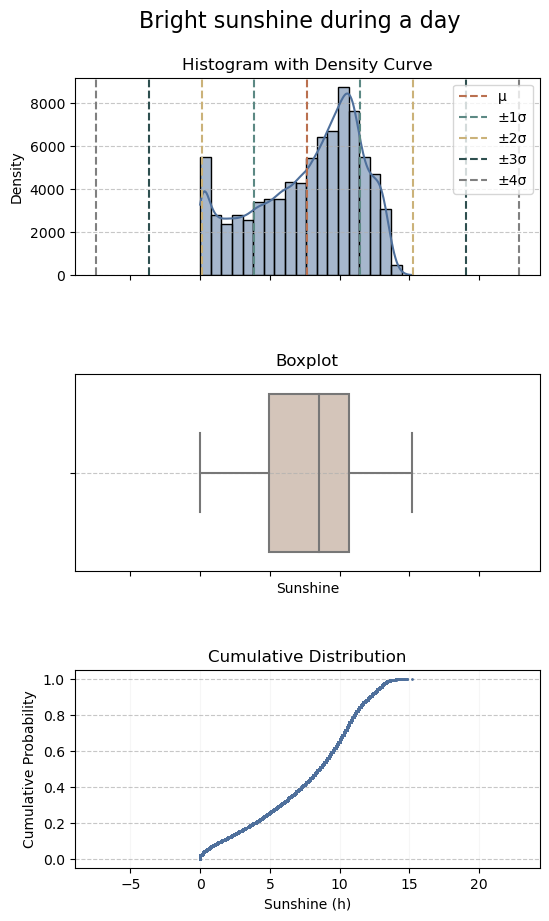

In [27]:
plot_analysis_numerical_variable(weather_data_sunshine,'Sunshine','Sunshine (h)','Bright sunshine during a day')

In [28]:
weather_data_partly_preprocessed['Sunshine'].describe()

count    48483.000000
mean         7.673108
std          3.784054
min          0.000000
25%          4.900000
50%          8.500000
75%         10.700000
max         14.500000
Name: Sunshine, dtype: float64

In [29]:
#weather_data_sunshine.isnull().sum()
weather_data_sunshine['Sunshine'].describe()

count    83801.000000
mean         7.677163
std          3.786574
min          0.000000
25%          4.900000
50%          8.500000
75%         10.700000
max         15.200000
Name: Sunshine, dtype: float64

In [ ]:
#should i generate only outputs from the range that i have or can i somehowe modify the range? There is a difference in max values
# if i use np.clip to ensure that the imputed values remain within the original range (bounded by the minimum and maximum values of the observed data)
# the results will be catastrophic, different mean std cdf -> i think better to stick to the first option

## <span style='color: #3F2E3E;'>Evaporation - continuous - ratio</span>
#### <span style='color: #A78295;'>Evaporation during a particular day. (millimeters)</span>

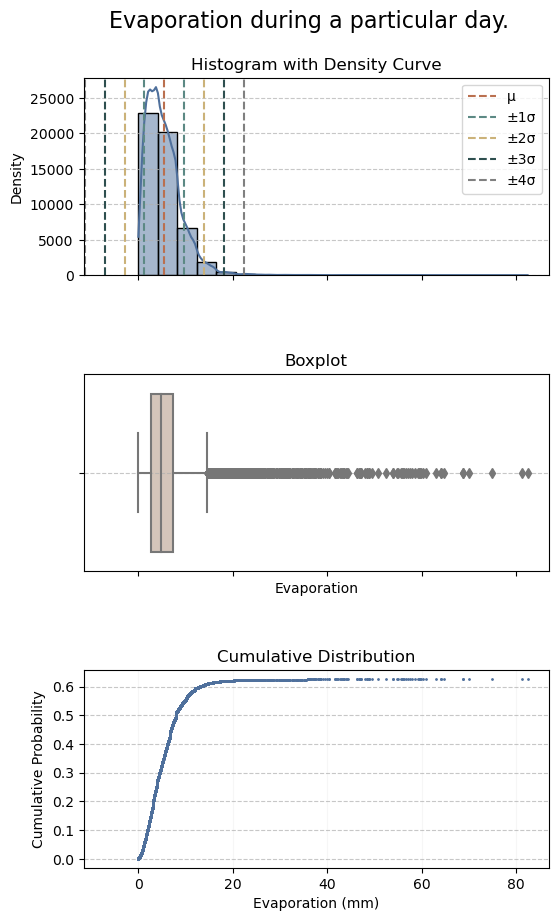

In [30]:
plot_analysis_numerical_variable(weather_data_sunshine,'Evaporation','Evaporation (mm)','Evaporation during a particular day.')

In [31]:
weather_data_evaporation = weather_data_sunshine.copy()

In [32]:
weather_data_evaporation = random_imputation(weather_data_evaporation, 'Evaporation')

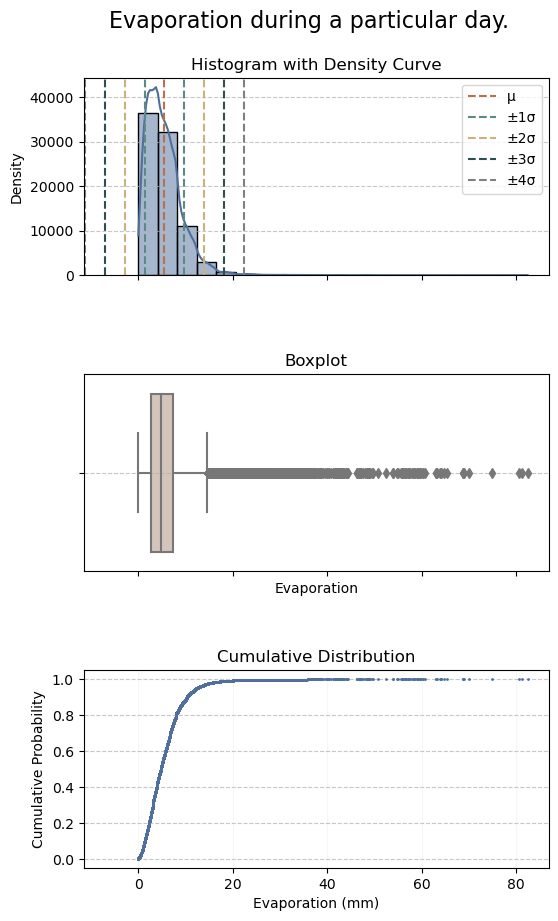

In [33]:
plot_analysis_numerical_variable(weather_data_evaporation,'Evaporation','Evaporation (mm)','Evaporation during a particular day.')

In [34]:
weather_data_sunshine['Evaporation'].describe()

count    52440.000000
mean         5.500011
std          4.201704
min          0.000000
25%          2.600000
50%          4.800000
75%          7.400000
max         82.400000
Name: Evaporation, dtype: float64

In [35]:
weather_data_evaporation['Evaporation'].describe()

count    83801.000000
mean         5.512717
std          4.205430
min          0.000000
25%          2.600000
50%          4.800000
75%          7.400000
max         82.400000
Name: Evaporation, dtype: float64

In [36]:
weather_data_preprocessed = weather_data_evaporation.copy()